# MDE REAP Project - Land Accounts <img align="right" src="./CSIRO logo.jpg">

##### Authors: Richard Lucas, Sana Khan, Glenn Newnham, Anna Richards, Kristen Williams

* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Background 

* Background on REAP
* Background on the MDE sub-project
* What are land accounts

## Description 

* Update once notebook is complete

This notebook will demonstrate how to create a change map using [DEA Land Cover](https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat) data. 
Topics include: 

1. Loading data for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map using layer descriptor data. 

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Load packages

Load key Python packages and supporting functions for the analysis. 

In [48]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import geopandas as gpd

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from datacube.utils.cog import write_cog

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [49]:
dc = datacube.Datacube(app="Land_cover_change_mapping")

## Select and view your study area

The sahpe file for the MDB is shown below. Coordinates are geographic.

<AxesSubplot:>

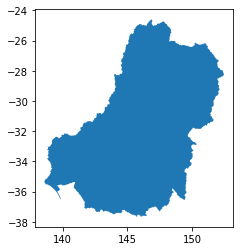

In [50]:
# The MDB is a large study area so we have to be careful how much we read in.

shpFilePath = "./Data/mdb_boundary.shp"  
df=gpd.read_file(shpFilePath)
df.plot()


In [174]:
minx, miny, maxx, maxy = df.geometry.total_bounds

# tile size
lon_buffer = abs(maxx - minx)/10.0
lat_buffer = abs(maxy - miny)/10.0

# Define Lat and Long ranges (remember this is very large for the MDB)
# be careeful at the edge of the bounding box as a tile may be all null
nx = 0
ny = 1
lon_range = (minx+(nx*lon_buffer), minx+((nx+1)*lon_buffer))
lat_range = (miny+(ny*lat_buffer), miny+((ny+1)*lat_buffer))

# Set the range of dates for the analysis
time_range = ("2019", "2020")

The following cell will display the area of interest on an interactive map. 
You can zoom in and out to better understand the area you'll be analysing. 

In [175]:
display_map(x=lon_range, y=lat_range)

## Load and view `level3` data 
The following cell will load `level3` data for the `lat_range`, `lon_range` and `time_range` we defined above.

In [176]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
# Some areas beyond the land have no data and this leads to an empty object being returned
# this needs a try-catch statements so that we know when this has occured e.g. at the 
# edge of the bounding box

lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=[
        "level3",
        "lifeform",
        "vegetation_cover",
        "water_seasonality",
        "water_state",
        "intertidal",
        "water_persistence",
        "bare_gradation",
        "full_classification",
    ],
    resolution=(-25, 25),
    **query
)

# dir(lc)

We can review the data by using the `plot_land_cover()` function.

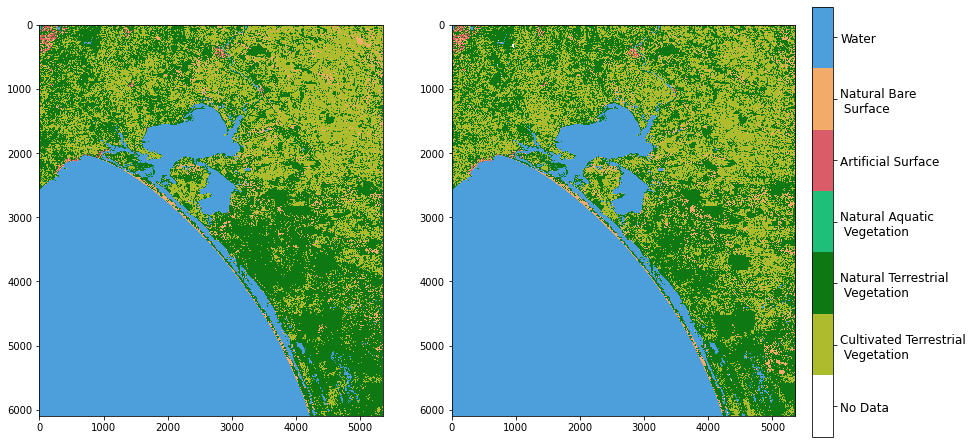

In [177]:
plot_land_cover(lc.level3)

## Plotting change maps

### Level 3 change maps 

In this section, we will create a plot that shows if a pixel changed class or remained the same between 2 discrete years. 
In this example, we are using 2010 and 2020.

In [178]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = True

In [179]:
# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [180]:
level_3 = lc.level3[0].drop_vars("time")

In [181]:
# Create a new Xarray.DataArray
change = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [182]:
# Get colour map for image
cmap, norm = lc_colourmap('level3_change_colour_scheme')

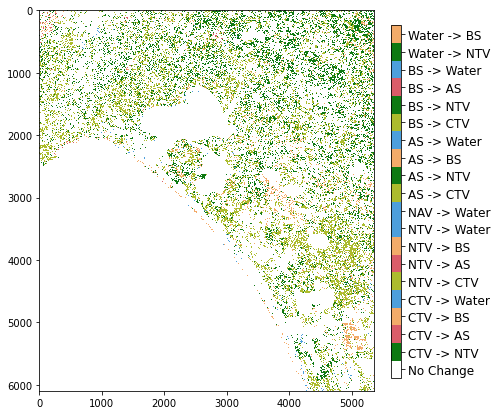

In [183]:
# Create figure with subplot and set size in inches
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

make_colorbar(fig, ax, measurement='level3_change_colour_scheme')

# Plot change data
img = ax.imshow(change, cmap=cmap, norm=norm, interpolation="nearest")

### Layer descriptor change maps 

In this section, we will plot two change maps using natural terrestrial vegetation (NTV) data and artificial surface (AS) data. 
Similar to above, we will use 2010 and 2020 data. 

#### Natural terrestrial vegetation change

In [184]:
# Make a mask of 1 for all increasing NTV that is anything going from another class to NTV
NTV_increase = np.where(
    (
        (change == 111112)
        | (change == 124112)
        | (change == 215112)
        | (change == 216112)
        | (change == 220112)
    ),
    1,
    0,
)

In [185]:
# Make a mask of -1 for all decreasing NTV that is anything going from NTV to another class
NTV_decrease = np.where(
    (
        (change == 112111)
        | (change == 112124)
        | (change == 112215)
        | (change == 112216)
        | (change == 112220)
    ),
    -1,
    0,
)

In [186]:
NTV_change = NTV_increase + NTV_decrease

In [187]:
# Create a new Xarray.DataArray
xr_ntvchange = xr.DataArray(
    data=NTV_change,
    coords=change.coords,
    dims=change.dims,
    name="ntv_change",
    attrs=None,
    indexes=change.indexes,
    fastpath=False,
)

The next cell plots the NTV change map, where red represents NTV loss and blue represents NTV gain.

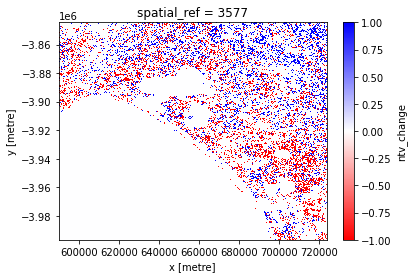

In [188]:
xr_ntvchange.plot.imshow(cmap="bwr_r")

#### Urban expansion

In [189]:
# Make a mask of 1 for all areas which became AS
AS_increase = np.where(
    (
        (change == 111215)
        | (change == 112215)
        | (change == 124215)
        | (change == 216215)
        | (change == 220215)
    ),
    1,
    0,
)

In [190]:
# Make a mask of -1 for all areas which changed from being AS to something else
AS_decrease = np.where(
    (
        (change == 215111)
        | (change == 215112)
        | (change == 215124)
        | (change == 215216)
        | (change == 215220)
    ),
    -1,
    0,
)

In [191]:
AS_change = AS_increase + AS_decrease

In [192]:
# Create a new Xarray.DataArray
xr_aschange = xr.DataArray(
    data=AS_change,
    coords=change.coords,
    dims=change.dims,
    name="as_change",
    attrs=None,
    indexes=change.indexes,
    fastpath=False,
)

The next cell plots the artificial surface change map, where blue represents artificial surface loss and pink represents artificial surface gain.

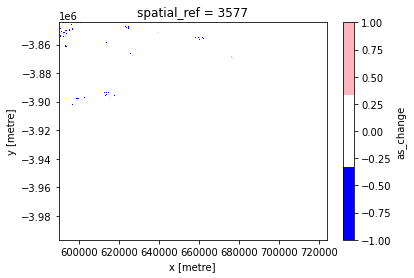

In [193]:
cmap = mcolours.ListedColormap(["b", "white", "lightpink"])
xr_aschange.plot.imshow(cmap=cmap)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)